回帰モデル用回帰函数の作成


In [1]:
from config.quality_metrics import qm_names

dataset_names = ["les_miserables", "1138_bus", "USpowerGrid"]
params_names = sorted(["number_of_pivots", "number_of_iterations", "eps"])

In [2]:
# span = 5

In [3]:
# import pandas as pd

# from config.paths import root_path


# data = pd.DataFrame()

# for dataset_name in dataset_names:
#     data_path = root_path.joinpath(
#         f"data/experiments/regression_analysis/grid/{dataset_name}.pkl"
#     )

#     data = pd.concat([data, pd.read_pickle(data_path)])

# data = data.set_index("data_id")

In [4]:
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# pa, pb, pc = params_names
# pavs = sorted(list(set(data[pa])))
# pbvs = sorted(list(set(data[pb])))
# pcvs = sorted(list(set(data[pc])))

# data["is_train"] = False
# for pav in tqdm(pavs):
#     for pbv in pbvs:
#         for pcv in pcvs:
#             for dataset_name in dataset_names:
#                 dd = data.query(
#                     f'dataset_name == "{dataset_name}" & {pa} == {pav} & {pb} == {pbv} & {pc} == {pcv}'
#                 )
#                 train_df, test_df = train_test_split(dd, test_size=0.2)
#                 for i,row in train_df.iterrows():
#                     data.at[i, "is_train"] = True

In [5]:
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# from tqdm import tqdm


# for qm_name in qm_names:
#     data[f"{qm_name}_ss"] = 0


# dqss = {}
# for dataset_name in dataset_names:
#     dd = data.query(f'dataset_name == "{dataset_name}" & is_train == True')
#     dqss[dataset_name] = {}
#     for qm_name in qm_names:
#         dqss[qm_name] = StandardScaler()
#         dqss[qm_name].fit(np.array(dd[qm_name]).reshape(-1, 1))


# for i, row in tqdm(data.iterrows()):
#     for qm_name in qm_names:
#         data.at[i, f"{qm_name}_ss"] = dqss[qm_name].transform(
#             np.array(row[qm_name]).reshape(-1, 1)
#         )[0][0]

In [6]:
# data.to_pickle(root_path.joinpath('data/experiments/regression_analysis/grid/test_and_train_with_ss.pkl'))

In [7]:
import pandas as pd
from config.paths import root_path

data = pd.read_pickle(
    root_path.joinpath(
        "data/experiments/regression_analysis/grid/test_and_train_with_ss.pkl"
    )
)

In [8]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

degs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cs = list(combinations(params_names, 2))


for deg in degs:
    model_df_data_array = []

    for c in tqdm(cs, position=0):
        pa = c[0]
        pb = c[1]
        pt = list(filter(lambda x: x != pa and x != pb, params_names))[0]

        pavs = sorted(list(set(data[pa])))
        pbvs = sorted(list(set(data[pb])))
        ptvs = sorted(list(set(data[pt])))

        for pav in tqdm(pavs, position=1, leave=False):
            for pbv in pbvs:
                model_df_data = {}
                dd = data.query(
                    f"{pa} == {pav} & {pb} == {pbv} & is_train == True"
                )
                x = np.array(dd[pt]).reshape(-1, 1)
                model_df_data[pa] = pav
                model_df_data[pb] = pbv
                for qm_name in qm_names:
                    model_df_data[qm_name] = Pipeline(
                        [
                            ("poly", PolynomialFeatures(degree=deg)),
                            ("linear", LinearRegression()),
                        ]
                    )

                    y = np.array(dd[f"{qm_name}_ss"]).reshape(-1, 1)
                    model_df_data[qm_name].fit(x, y)

                model_df_data_array.append(model_df_data)

    model_df = pd.DataFrame(model_df_data_array)
    model_df.to_pickle(
        root_path.joinpath(
            f"data/experiments/regression_analysis/grid/grid_models_poly_{deg}.pkl"
        )
    )

100%|██████████| 3/3 [00:29<00:00,  9.77s/it]


In [10]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
import lightgbm as lgb

import pandas as pd
from config.paths import root_path

data = pd.read_pickle(
    root_path.joinpath(
        "data/experiments/regression_analysis/grid/test_and_train_with_ss.pkl"
    )
)

cs = list(combinations(params_names, 2))

model_df = pd.DataFrame()
model_df_data_array = []

for c in tqdm(cs, position=0):
    pa = c[0]
    pb = c[1]
    pt = list(filter(lambda x: x != pa and x != pb, params_names))[0]

    pavs = sorted(list(set(data[pa])))
    pbvs = sorted(list(set(data[pb])))
    ptvs = sorted(list(set(data[pt])))

    for pav in tqdm(pavs, position=1, leave=False):
        for pbv in pbvs:
            model_df_data = {}
            dd = data.query(
                f"{pa} == {pav} & {pb} == {pbv} & is_train == True"
            )
            x = np.array(dd[pt]).reshape(-1, 1)
            model_df_data[pa] = pav
            model_df_data[pb] = pbv
            for qm_name in qm_names:
                model_df_data[qm_name] = lgb.LGBMRegressor()

                y = np.array(dd[f"{qm_name}_ss"]).reshape(-1, 1)
                model_df_data[qm_name].fit(x, y)

            model_df_data_array.append(model_df_data)

model_df = pd.DataFrame(model_df_data_array)
model_df.to_pickle(
    root_path.joinpath(
        f"data/experiments/regression_analysis/grid/grid_models_lightgbm.pkl"
    )
)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/fuga_takata/dev/vdslab-project/hyperparameter_optimization/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fuga_takata/dev/vdslab-project/hyperparameter_optimization/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fuga_takata/dev/vdslab-project/hyperparameter_optimization/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, wa

In [11]:
import pandas as pd
from config.paths import root_path

data = pd.read_pickle(
    root_path.joinpath(
        "data/experiments/regression_analysis/grid/test_and_train_with_ss.pkl"
    )
)
# model_df = pd.read_pickle(
#     root_path.joinpath(
#         "data/experiments/regression_analysis/grid/grid_models_lgb.pkl"
#     )
# )

In [12]:
# parameter（名前＋値）を3つ受け取って、評価値を返す関数
from itertools import combinations
import numpy as np


def regression_func(ps, qm_name, model_df):
    qs = []
    cs = list(combinations(ps, 2))

    for c in cs:
        p1 = c[0]
        p2 = c[1]
        pt = list(
            filter(
                lambda x: x[0] != p1[0] and x[0] != p2[0],
                ps,
            )
        )[0]

        mdf = model_df.query(f"{p1[0]} == {p1[1]} & {p2[0]} == {p2[1]}")
        target_model = mdf[qm_name].values[0]
        q = target_model.predict(np.array([pt[1]]).reshape(-1, 1))[0]
        if type(q) == type(np.array([])):
            q = q[0]
        qs.append(q)

    result = sum(qs) / len(qs)
    return result

In [13]:
# regression_func(
#     [
#         ["eps", 0.1],
#         ["number_of_iterations", 100],
#         ["number_of_pivots", 50],
#     ],
#     "stress",
# )

In [14]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import r2_score


cs = list(combinations(params_names, 2))
# degs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
degs = [5]

models = [
    # {
    #     "model_df": pd.read_pickle(
    #         root_path.joinpath(
    #             f"data/experiments/regression_analysis/grid/grid_models_poly_{deg}.pkl"
    #         )
    #     ),
    #     "name": deg,
    # }
    # for deg in degs
]
models.append(
    {
        "model_df": pd.read_pickle(
            root_path.joinpath(
                f"data/experiments/regression_analysis/grid/grid_models_lightgbm.pkl"
            )
        ),
        "name": "lgb",
    }
)

ss = []
results = []
for model in models:
    result_array = []

    for c in tqdm(cs, position=0):
        pa = c[0]
        pb = c[1]
        pt = list(filter(lambda x: x != pa and x != pb, params_names))[0]

        pavs = sorted(list(set(data[pa])))[::5]
        pbvs = sorted(list(set(data[pb])))[::5]
        ptvs = sorted(list(set(data[pt])))[::5]

        dd_train = data.query(f"is_train == True")
        dd_test = data.query(f"is_train == False")
        for ptv in tqdm(ptvs, position=1, leave=False):
            for pav in pavs:
                for pbv in pbvs:
                    result = {}
                    result[pa] = pav
                    result[pb] = pbv
                    result[pt] = ptv

                    for qm_name in qm_names:
                        result[qm_name] = regression_func(
                            [
                                [pa, pav],
                                [pb, pbv],
                                [pt, ptv],
                            ],
                            qm_name=qm_name,
                            model_df=model["model_df"],
                        )
                        l = dd_test.query(
                            f"{pa} == {pav} & {pb} == {pbv} & {pt} == {ptv}"
                        )

                        result[f"{qm_name}_test_labels"] = list(
                            l[f"{qm_name}_ss"].values
                        )

                    result_array.append(result)

    result = pd.DataFrame(result_array)
    results.append(result)

100%|██████████| 3/3 [00:24<00:00,  8.06s/it]


In [15]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import r2_score


cs = list(combinations(params_names, 2))
degs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# degs = []

models = [
    {
        "model_df": pd.read_pickle(
            root_path.joinpath(
                f"data/experiments/regression_analysis/grid/grid_models_poly_{5}.pkl"
            )
        ),
        "name": 5,
    }
]

ppp = {
    "number_of_iterations": [
        10,
        20,
        30,
        40,
        50,
        60,
        70,
        80,
        90,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        170,
        180,
        190,
        200,
    ],
    "number_of_pivots": [
        5,
        10,
        15,
        20,
        25,
        30,
        35,
        40,
        45,
        50,
        55,
        60,
        65,
        70,
        75,
        80,
        85,
        90,
        95,
        100,
    ],
    "eps": [
        0.05,
        0.1,
        0.15000000000000002,
        0.2,
        0.25,
        0.30000000000000004,
        0.35000000000000003,
        0.4,
        0.45,
        0.5,
        0.55,
        0.6000000000000001,
        0.65,
        0.7000000000000001,
        0.75,
        0.8,
        0.8500000000000001,
        0.9,
        0.9500000000000001,
        1.0,
    ],
}

ss = []
results = []
for model in models:
    result_array = []

    for c in tqdm(cs):
        pa = c[0]
        pb = c[1]
        pt = list(filter(lambda x: x != pa and x != pb, params_names))[0]

        pavs = sorted(list(set(data[pa])))[::4]
        pbvs = sorted(list(set(data[pb])))[::4]
        ptvs = sorted(list(set(data[pt])))[::4]

        dd_train = data.query(f"is_train == False")
        dd_test = data.query(f"is_train == True")
        for ptv in ptvs:
            for pav in pavs:
                for pbv in pbvs:
                    result = {}
                    result[pa] = pav
                    result[pb] = pbv
                    result[pt] = ptv

                    for qm_name in qm_names:
                        result[qm_name] = regression_func(
                            [
                                [pa, pav],
                                [pb, pbv],
                                [pt, ptv],
                            ],
                            qm_name=qm_name,
                            model_df=model["model_df"],
                        )
                        l = dd_test.query(
                            f"{pa} == {pav} & {pb} == {pbv} & {pt} == {ptv}"
                        )

                        result[f"{qm_name}_test_labels"] = list(
                            l[f"{qm_name}_ss"].values
                        )

                    result_array.append(result)

    result = pd.DataFrame(result_array)
    results.append(result)

100%|██████████| 3/3 [00:47<00:00, 15.87s/it]


In [16]:
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# from itertools import combinations
# from sklearn.metrics import r2_score


# cs = list(combinations(params_names, 2))
# degs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# # degs = []

# models = [
#     {
#         "model_df": pd.read_pickle(
#             root_path.joinpath(
#                 f"data/experiments/regression_analysis/grid/grid_models_poly_{5}.pkl"
#             )
#         ),
#         "name": 5,
#     }
# ]

# ppp = {
#     'number_of_iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
#     'number_of_pivots': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100] ,
#     'eps': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]
# }

# ss = []
# results = []
# for model in models:
#     result_array = []

#     for c in tqdm(cs):
#         pa = c[0]
#         pb = c[1]
#         pt = list(filter(lambda x: x != pa and x != pb, params_names))[0]

#         pavs = sorted(list(set(data[pa])))[::4]
#         pbvs = sorted(list(set(data[pb])))[::4]
#         ptvs = sorted(list(set(data[pt])))[::4]

#         dd_train = data.query(f"is_train == False")
#         dd_test = data.query(f"is_train == True")
#         for ptv in ptvs:
#             for pav in pavs:
#                 for pbv in pbvs:
#                     result = {}
#                     result[pa] = pav
#                     result[pb] = pbv
#                     result[pt] = ptv

#                     for qm_name in qm_names:
#                         result[qm_name] = regression_func(
#                             [
#                                 [pa, pav],
#                                 [pb, pbv],
#                                 [pt, ptv],
#                             ],
#                             qm_name=qm_name,
#                             model_df=model["model_df"],
#                         )
#                         l = dd_test.query(
#                             f"{pa} == {pav} & {pb} == {pbv} & {pt} == {ptv}"
#                         )

#                         result[f"{qm_name}_test_labels"] = list(
#                             l[f"{qm_name}_ss"].values
#                         )

#                     result_array.append(result)

#     result = pd.DataFrame(result_array)
#     results.append(result)

In [17]:
print(sorted(list(set(data[pa]))),
sorted(list(set(data[pb]))),
sorted(list(set(data[pt]))))
'gabriel_graph_property': 42.27572535654411, 'ideal_edge_lengths': 66.95490573710892, 'neighborhood_preservation': 161.03723505431273, 'node_resolution': 13.65675068257192, 'stress': 33.441330735989595}

SyntaxError: unmatched '}' (1170058237.py, line 4)

In [18]:
from statistics import mean

for result in results:
    s = {}
    for qm_name in qm_names:
        s[qm_name] = 0

    for i, row in result.iterrows():
        d = row.to_dict()
        for qm_name in qm_names:
            for l in d[f"{qm_name}_test_labels"]:
                s[qm_name] += (l - d[qm_name]) ** 2
            # s[qm_name] += (mean(d[f"{qm_name}_test_labels"]) - d[qm_name]) ** 2
            # for l in d[f"{qm_name}_test_labels"]:
            #     s[qm_name] += (l - d[qm_name]) ** 2
    print(model["name"], s)
    ss.append(s)

5 {'angular_resolution': 1891183.6641239899, 'aspect_ratio': 28083.5054491031, 'crossing_angle': 153326.42041311937, 'crossing_number': 74243.61874333797, 'gabriel_graph_property': 16729.274917960887, 'ideal_edge_lengths': 30814.141349813515, 'neighborhood_preservation': 6845672.947368203, 'node_resolution': 608927.4165414636, 'stress': 43113.19210639785}


In [ ]:
s = {}
for qm_name in qm_names:
    s[qm_name] = 0

for i, row in result.iterrows():
    d = row.to_dict()
    for qm_name in qm_names:
        for l in d[f"{qm_name}_test_labels"]:
            s[qm_name] += (l - d[qm_name]) ** 2

In [ ]:
!say finished
!say finished
!say finished

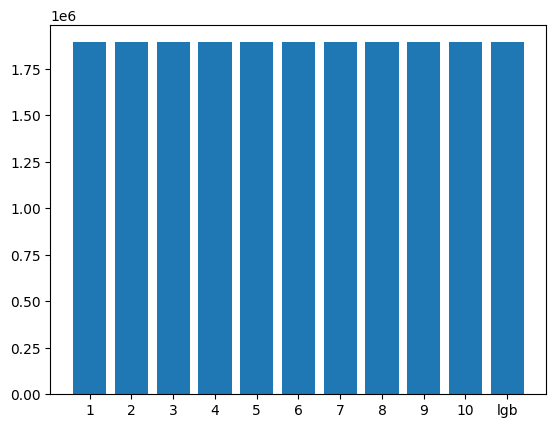

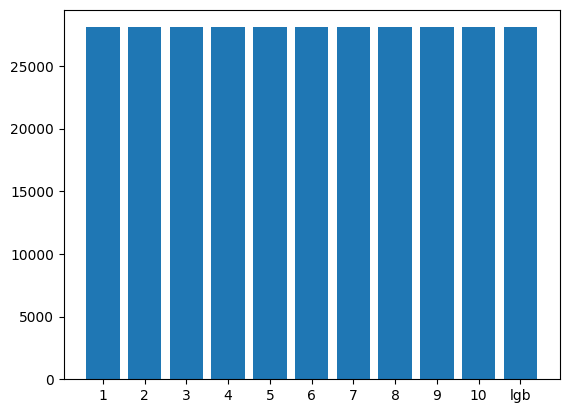

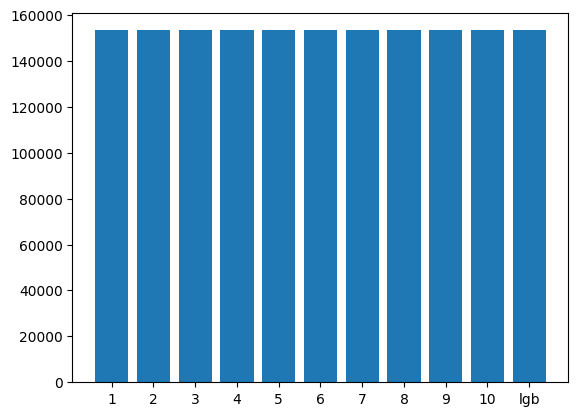

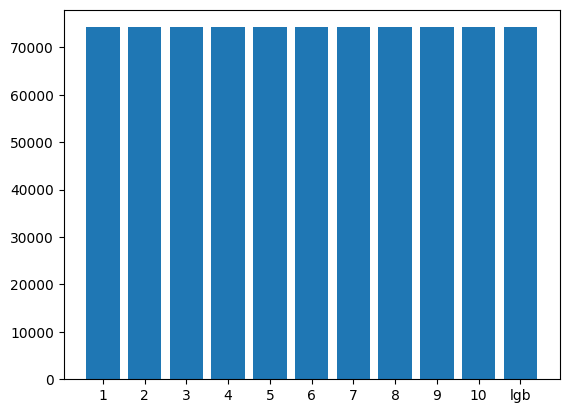

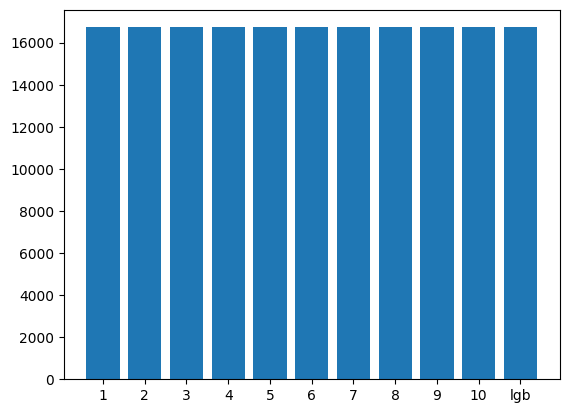

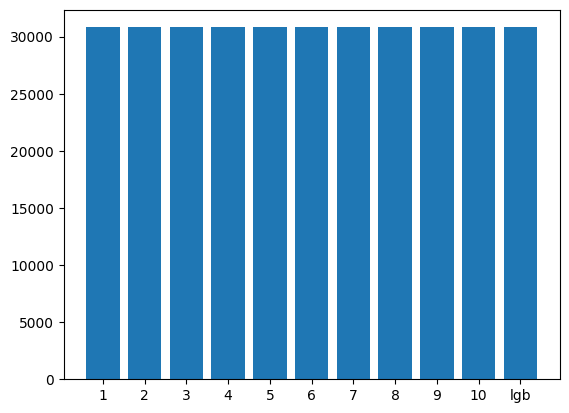

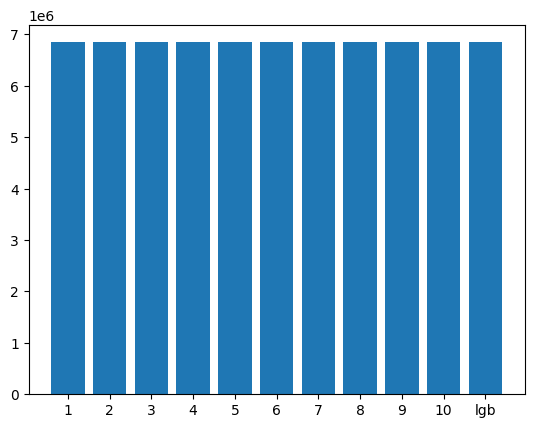

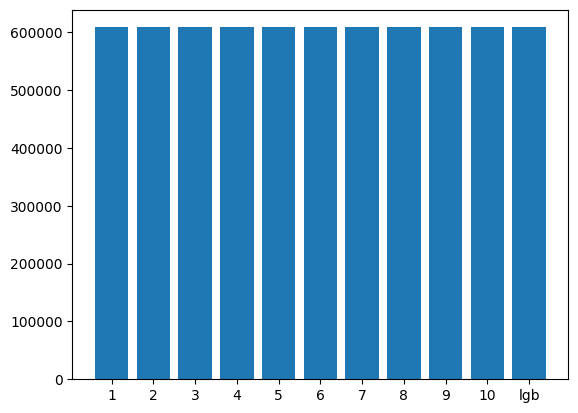

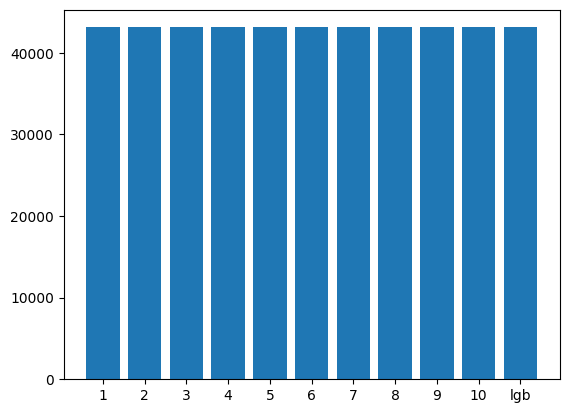

In [19]:
import matplotlib.pyplot as plt

bd = {}
for qm_name in qm_names:
    bd[qm_name] = []
for s in ss:
    for qm_name in qm_names:
        bd[qm_name].append(s[qm_name])

for qm_name in qm_names:
    plt.bar(
        ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "lgb"], bd[qm_name]
    )
    plt.show()

In [20]:
results[0]

eps  number_of_iterations  number_of_pivots  angular_resolution  \
0    0.05                    10                 5          -22.543969   
1    0.05                    50                 5          -20.459492   
2    0.05                    90                 5          -20.386760   
3    0.05                   130                 5          -20.391222   
4    0.05                   170                 5          -20.516566   
..    ...                   ...               ...                 ...   
370  0.85                   170                 5          -20.606253   
371  0.85                   170                25          -20.694078   
372  0.85                   170                45          -20.818328   
373  0.85                   170                65          -20.812031   
374  0.85                   170                85          -20.889171   

                        angular_resolution_test_labels  aspect_ratio  \
0    [-31.815873979211737, -31.635513569678142, -31...      1.588465   
1    [-31.6151978391833, -31.831676971737085, -31.7...      2.551329   
2    [-31.840365415496876, -31.47375494292578, -31....      3.048297   
3    [-31.789215768868566, -31.554226065697208, -31...      3.090248   
4    [-31.836989918546642, -31.110503471488084, -31...      2.850855   
..                                                 ...           ...   
370  [-31.564308567703023, -31.748256008779173, -31...      2.818299   
371  [-32.02022448157772, -32.128977197137054, -32....      0.469387   
372  [-31.97364482310674, -32.0507355972171, -32.00...      0.087720   
373  [-31.90582469805613, -32.0716425895388, -32.03...     -0.057566   
374  [-32.00553156049097, -31.959157938006694, -32....     -0.202761   

                              aspect_ratio_test_labels  crossing_angle  \
0    [5.118536957282069, 1.7627859319018901, 2.2233...       -2.757517   
1    [5.678679173479911, 5.3812656846867455, 1.0996...       -4.604486   
2    [5.779206781236556, 3.827848488775575, 7.13948...       -4.750556   
3    [0.9028949952347716, 0.3027332335967663, 9.200...       -4.715995   
4    [5.147121521639082, 1.2640298366841514, 5.2978...       -4.850765   
..                                                 ...             ...   
370  [9.133511464919996, 4.175286770412804, 8.34613...       -4.585228   
371  [-1.5204804842910615, -1.157401782708072, -1.0...       -5.246444   
372  [-1.5266138973575107, -2.2310003558621467, -0....       -5.406670   
373  [-1.2173971627456288, -1.864022380608469, -1.1...       -5.478512   
374  [-2.096798909520525, -2.941086974803156, -1.25...       -5.608359   

                            crossing_angle_test_labels  crossing_number  ...  \
0    [-8.378392674245015, -8.382635483899993, -8.46...        -1.066963  ...   
1    [-8.392042919939147, -8.451774457100681, -8.43...        -3.066948  ...   
2    [-8.45717840303219, -8.338048527488198, -8.428...        -3.049353  ...   
3    [-8.440283463942333, -8.438490213546524, -8.42...        -3.075118  ...   
4    [-8.46357327627277, -8.320795711584406, -8.389...        -3.135120  ...   
..                                                 ...              ...  ...   
370  [-8.348956158483526, -8.48657399010674, -8.420...        -2.959985  ...   
371  [-8.499737682819877, -8.516599033201338, -8.49...        -3.361361  ...   
372  [-8.483789842607536, -8.489358409457001, -8.51...        -3.516508  ...   
373  [-8.438623632004251, -8.520426665880665, -8.49...        -3.626335  ...   
374  [-8.496346914789427, -8.468216009038521, -8.51...        -3.721688  ...   

    gabriel_graph_property                 gabriel_graph_property_test_labels  \
0                 4.634147  [-0.3081720504063539, -0.30836361053962547, -0...   
1                -0.024159  [-0.3086246398982384, -0.30885664395152174, -0...   
2                -0.000154  [-0.3087121038447519, -0.3083295664016119, -0....   
3                -0.070883  [-0.30870208751523076, -0.30869143188792403, -...   
4        

In [21]:
list(results[0]["aspect_ratio_test_labels"])

[[5.118536957282069,
  1.7627859319018901,
  2.22332770097145,
  0.8341796839292088,
  -2.621638257244301,
  -2.2696349370615,
  3.5505509195968608,
  -1.7607782788612447,
  2.5645386981390463,
  0.3219248809337206,
  1.2517182411128114,
  0.7243486980293885,
  3.711169222969679,
  4.193819873752042,
  2.12137324788642,
  0.6664069354583941,
  0.6848663858505192,
  1.19030034827317,
  0.5042433643716362,
  1.7192310450003019,
  5.658388508637996,
  1.8332385862540594,
  -0.9368545313676417,
  0.8746180402451136],
 [5.678679173479911,
  5.3812656846867455,
  1.0996306820261987,
  1.6749757330134234,
  5.085527439396543,
  4.006611412295996,
  4.664856465697487,
  -1.331091317930298,
  1.0208927932115335,
  5.156741174202214,
  1.2118228947599359,
  6.783993283331017,
  0.5359300175599961,
  1.0517158294906077,
  3.9365356877319932,
  2.2492809776884646,
  4.676324662815611,
  2.665971803892551,
  3.5801464067573847,
  1.9474627538228553,
  4.119046246502577,
  -2.4320194669895967,
  0.9